In [48]:
from pathlib import Path
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": "CMU Sans Serif",
    "font.size": 18
})

In [2]:
import yaml
import json
import seaborn as sns

In [38]:
tau1 = np.load("dynamical/data/MackeyGlass/tau_1/0.npy")[:100]
tau25 = np.load("dynamical/data/MackeyGlass/tau_25/0.npy")[:100]
tau49 = np.load("dynamical/data/MackeyGlass/tau_49/0.npy")[:100]

tau1_s = [{"t": i, "tau": 1, **dict(enumerate(x))} for i, x in enumerate(tau1)]
tau25_s = [{"t": i, "tau": 25, **dict(enumerate(x))} for i, x in enumerate(tau25)]
tau49_s = [{"t": i, "tau": 49, **dict(enumerate(x))} for i, x in enumerate(tau49)]
df_taus = pd.DataFrame(tau1_s + tau25_s + tau49_s)
df_taus = df_taus.melt(id_vars=["t", "tau"], var_name="i", value_name="x")
df_taus

,t,tau,i,x
0,0,1,0,0.511781
1,1,1,0,0.513700
2,2,1,0,0.517979
3,3,1,0,0.524370
4,4,1,0,0.532463
...,...,...,...,...
2995,95,49,9,0.321576
2996,96,49,9,0.349298
2997,97,49,9,0.381909
2998,98,49,9,0.418748


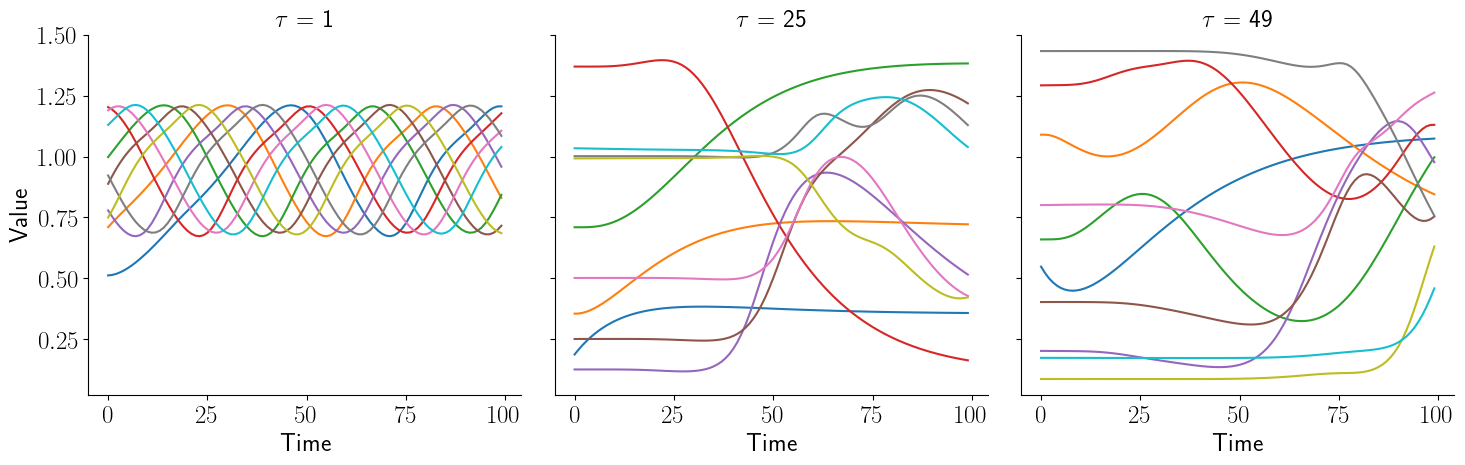

In [51]:
s = sns.relplot(df_taus, x="t", y="x", col="tau", kind="line", hue="i", palette="tab10", legend=False)
s.set_axis_labels("Time", "Value")
s.set_titles("$\\tau$ = {col_name}")

In [3]:
def read_run(run, experiment):
  data = {}
  with open(run / "files" / "config.yaml") as fp:
    config = yaml.load(fp, yaml.SafeLoader)
    if not config["experiment"]["value"] == experiment:
      return {}
    for k in ["a", "b", "c", "d", "ssm_act"]:
      val = config[f"{k}_bits"]["value"]
      data[k] = val if val is not None else -1
    data["tau"] = int(config["tau"]["value"][4:])
  with open(run / "files" / "wandb-summary.json") as fp:
    json_data = json.load(fp)
    if "Best Val Loss" not in json_data:
      return {}
    data["loss"] = json_data["Best Val Loss"]
  return data

read_run(Path("wandb/run-20240524_052234-f9iusgu6"), "mackey_glass")

{}

In [4]:
runs = list(Path("wandb").glob("run-*"))
run_data = [read_run(x, "mackey_glass") for x in runs]
df = pd.DataFrame(run_data).dropna()
df.head()

,a,b,c,d,ssm_act,tau,loss
0,-1.0,-1.0,-1.0,-1.0,6.0,225.0,34.634060
1,5.0,-1.0,-1.0,-1.0,-1.0,209.0,37.781586
2,8.0,-1.0,-1.0,-1.0,-1.0,97.0,35.263592
3,3.0,-1.0,-1.0,-1.0,-1.0,225.0,53.409946
4,5.0,-1.0,-1.0,-1.0,-1.0,113.0,37.555450


<Axes: xlabel='a', ylabel='tau'>

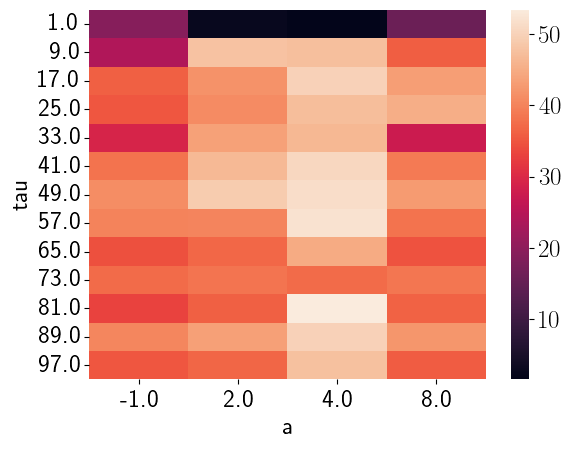

In [38]:
df_all = df[(df["a"] == df["b"]) & (df["b"] == df["c"]) & (df["c"] == df["d"]) & (df["d"] == df["ssm_act"]) & (df["loss"] < 10000) & (df["tau"] < 100)]
df_all = df_all[df_all["a"].isin([-1, 2, 4, 8])]
df_all_g = df_all.groupby(["tau", "a"]).mean("loss").reset_index().pivot(index="tau", columns="a", values="loss")
sns.heatmap(df_all_g)

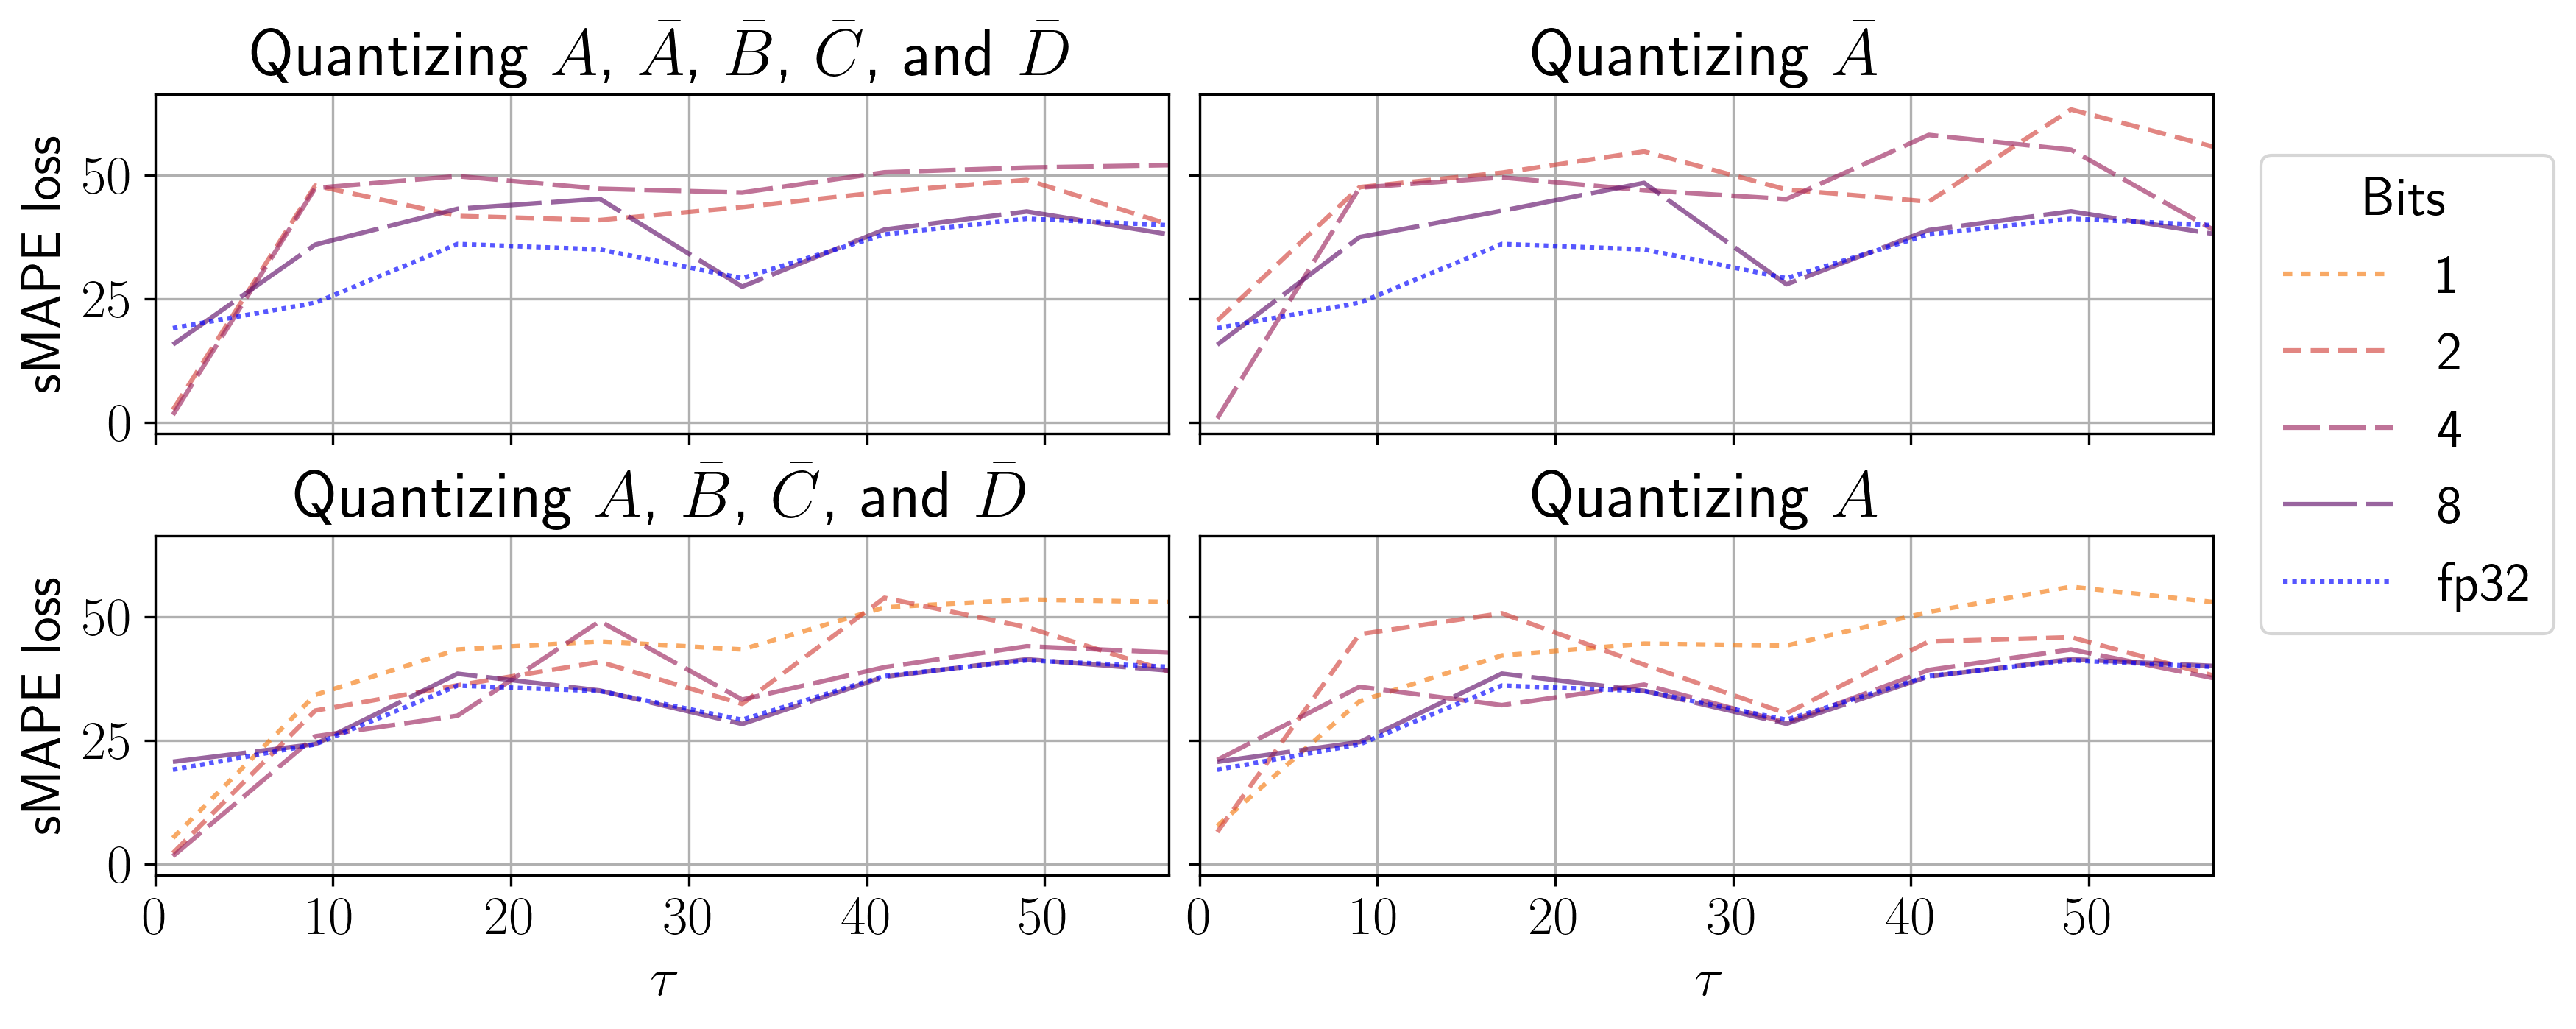

In [56]:
order = [1, 2, 4, 8, -1]
# palette = list(sns.color_palette("rocket", 10))
palette = sns.color_palette("inferno_r", len(order) + 1)[1:]
palette = palette[:-1] + ["blue"]
labels = order + ["fp32"] 
opt = {
  "hue_order": order,
  "palette": palette,
  "alpha": 0.66,
  "dashes": {
    1: [2, 2],
    2: [4, 2],
    4: [8, 2],
    8: [16, 2],
    -1: [1, 1]
  },
}
f, ((a1, a2), (a3, a4)) = plt.subplots(2, 2, figsize=(12, 5), dpi=300, sharey=True, sharex=True)

# Plot 1: Everything quantized
ax = a1
df_all = df[(df["a"] == df["b"]) & (df["b"] == df["c"]) & (df["c"] == df["d"]) & (df["d"] == df["ssm_act"]) & (df["loss"] < 10000)]
df_all = df_all[df_all["a"].isin(order)]
df_all = df_all.groupby(["a", "tau"]).mean()
sns.lineplot(df_all, x="tau", y="loss", hue="a", ax=ax, style="a", legend=False, **opt)
#ax.set_title("$W$f $A$x $\\bar{A}$x")
ax.set_title("Quantizing $A$, $\\bar{A}$, $\\bar{B}$, $\\bar{C}$, and $\\bar{D}$")

# Plot 2: A quantized
ax = a2
df_a = df[(df["b"] == -1) & (df["d"] == -1)& (df["d"] == -1) & (df["ssm_act"] == -1) & (df["loss"] < 10000)]
df_a = df_a[df_a["a"].isin(order)]
df_a = df_a.groupby(["a", "tau"]).mean()
sns.lineplot(df_a, x="tau", y="loss", hue="a", ax=ax, style="a", legend=False, **opt)
ax.set_title("Quantizing $\\bar{A}$")

# Plot 4: A fp, bcd + act quantized
ax = a3
df_tau = df[(df["a"] == -1) & (df["b"] == df["c"]) & (df["c"] == df["d"]) & (df["d"] == df["ssm_act"]) & (df["loss"] < 10000)]
df_tau = df_tau[df_tau["ssm_act"].isin(order)]
df_tau = df_tau.groupby(["ssm_act", "tau"]).mean()
sns.lineplot(df_tau, x="tau", y="loss", hue="ssm_act", ax=ax, style="ssm_act", legend=False, **opt)
ax.set_title("Quantizing $A$, $\\bar{B}$, $\\bar{C}$, and $\\bar{D}$")

# Plot 3: Activation quantized
ax = a4
df_act = df[(df["b"] == -1) & (df["d"] == -1)& (df["d"] == -1) & (df["a"] == -1) & (df["loss"] < 10000)]
df_act = df_act[df_act["ssm_act"].isin(order)]
df_act = df_act.groupby(["ssm_act", "tau"]).mean()
sns.lineplot(df_act, x="tau", y="loss", hue="ssm_act", style="ssm_act", ax=ax, legend="full", **opt)
ax.set_title("Quantizing $A$")

# Legend
ax.legend(bbox_to_anchor=(1.02, 2.2), title="Bits", loc="upper left")
ax.get_legend().texts[-1].set_text("fp32")
# ax.get_legend().set_title("Bits")

for a in [a1, a2, a3, a4]:
  a.set_xlim(0, 57)
  a.set_ylabel("sMAPE loss")
  a.set_xlabel(r"$\tau$")
  a.grid(True)

plt.tight_layout()
plt.subplots_adjust(hspace=0.3, wspace=0.03)

Text(39.01277430555556, 0.5, 'sMAPE loss')

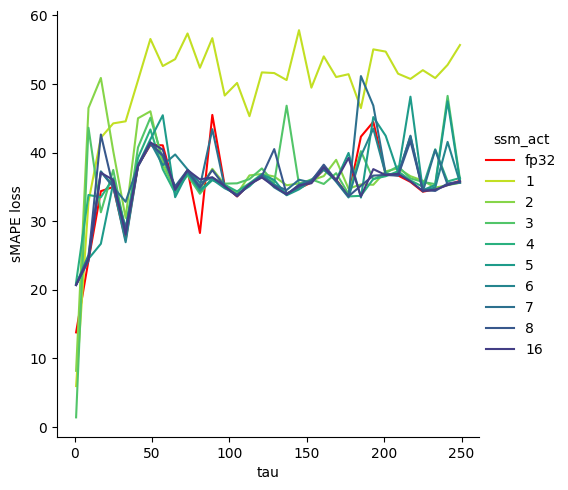

In [7]:
df_act = df[(df["b"] == -1) & (df["d"] == -1)& (df["d"] == -1) & (df["a"] == -1) & (df["loss"] < 10000)]
df_act = df_act.groupby(["tau", "ssm_act"]).mean().reset_index()
palette = sns.color_palette("viridis_r", 10)
palette = ["red"] + palette[:-1]
labels = ["fp32"] + [f"{float(x):.0f}" for x in df_act["ssm_act"].unique()][1:]
ax = sns.relplot(df_act, x="tau", y="loss", kind="line", hue="ssm_act", palette=palette)
for t, l in zip(ax.legend.texts, labels):
    t.set_text(l)
ax.ax.set_ylabel("sMAPE loss")

<Axes: xlabel='a', ylabel='tau'>

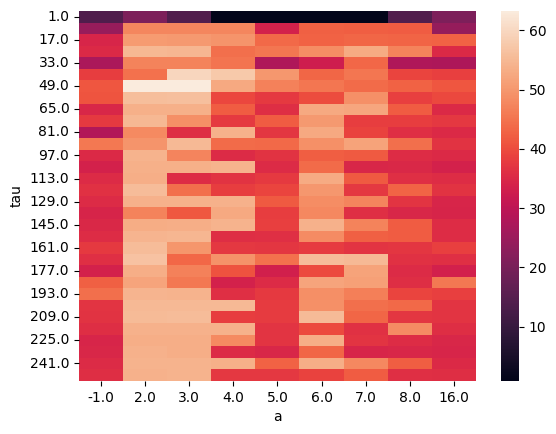

In [8]:
df_tau = df[(df["b"] == -1) & (df["d"] == -1)& (df["d"] == -1) & (df["ssm_act"] == -1) & (df["loss"] < 10000)]
df_tau_pivot = df_tau.pivot_table(index="tau", columns="a", values="loss")
sns.heatmap(df_tau_pivot)

In [113]:
df[(df["a"] == -1) & (df["b"] == -1)& (df["d"] == -1)& (df["d"] == -1)]

,a,b,c,d,ssm_act,tau,loss
1,-1.0,-1.0,-1.0,-1.0,2.0,233.0,35.082073
2,-1.0,-1.0,-1.0,-1.0,6.0,1.0,20.774975
4,-1.0,-1.0,-1.0,-1.0,6.0,49.0,41.411385
5,-1.0,-1.0,-1.0,-1.0,2.0,177.0,34.232624
6,-1.0,-1.0,-1.0,-1.0,1.0,49.0,53.663971
...,...,...,...,...,...,...,...
659,-1.0,-1.0,-1.0,-1.0,1.0,129.0,52.851940
667,-1.0,-1.0,-1.0,-1.0,2.0,81.0,34.515503
668,-1.0,-1.0,-1.0,-1.0,8.0,113.0,35.228645
670,-1.0,-1.0,-1.0,-1.0,16.0,121.0,36.220284


(0.0, 100.0)

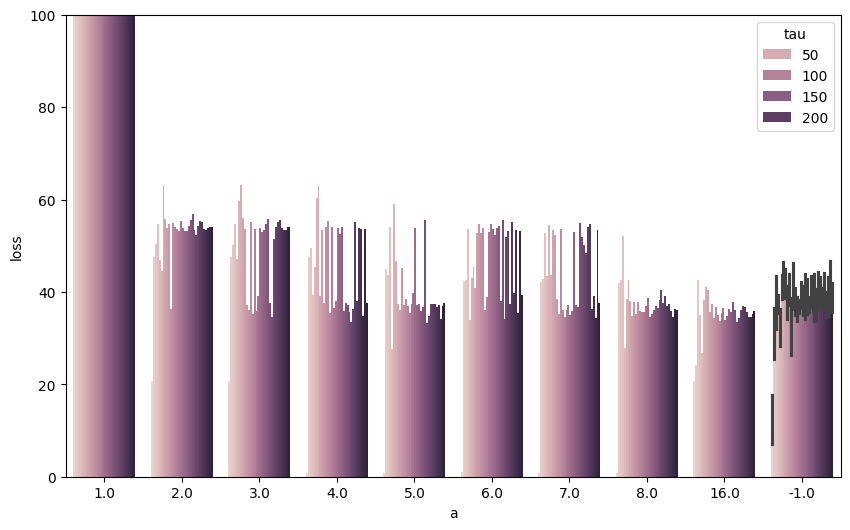

In [145]:
plt.figure(figsize=(10, 6))
ax = sns.barplot(data=df, x="a", y="loss", order=sorted(df["a"].unique())[1:] + [-1], hue="tau")
ax.set_ylim(0, 100)

(0.0, 100.0)

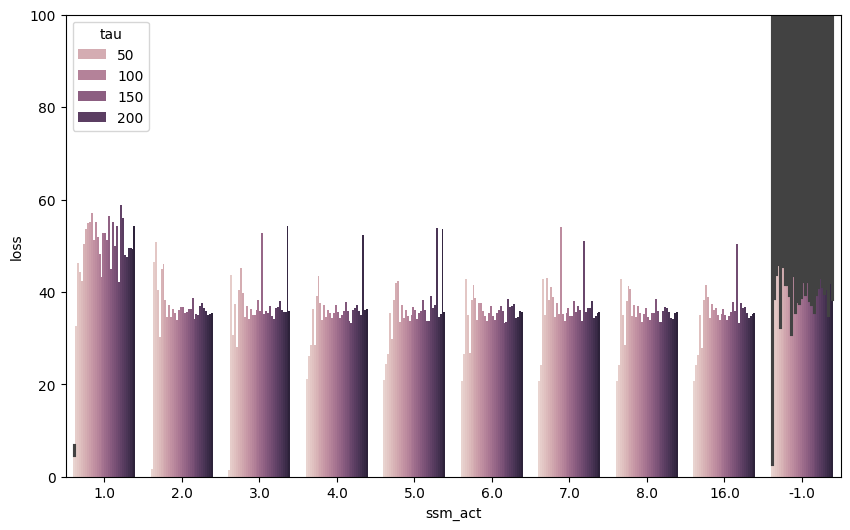

In [148]:
plt.figure(figsize=(10, 6))
ax = sns.barplot(data=df, x="ssm_act", y="loss", order=sorted(df["a"].unique())[1:] + [-1], hue="tau")
ax.set_ylim(0, 100)